In [1]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(0) 

In [3]:
torch.cuda.empty_cache()

In [4]:
class SmallDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file).sample(5000)[-1000:-500]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        embedding_path = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        embedding = torch.load(embedding_path)[0,0,1:,:]
        label = literal_eval(self.labels.iloc[idx, 1])
        if self.transform:
            embedding = self.transform(embedding)
        return embedding, label, embedding_path

In [5]:
dataset_orig = SmallDataset(csv_file='../data/rmsd_dataset.csv',
                                    root_dir='/mnt/nasdata/vera/msa_transformer_embeddings/')

In [6]:
feature_tensor = torch.load('../data/500_protein_dataset/500_protein_tensor.pt')
labels_df = pd.read_csv('../data/500_protein_dataset/500_protein_labels.csv')
print(feature_tensor.shape)
print(labels_df.shape)

torch.Size([112801, 768])
(112801, 4)


In [7]:
# Iterate over different rmsd thresholds and print the percentage of the dataset that is selected
for i in range(1,10):
    select = labels_df['rmsd'] > i/5
    select_df = labels_df[select]
    full_length = len(labels_df)
    select_length = len(select_df)
    print("{:.2%}".format(select_length/full_length))

21.18%
13.67%
10.85%
9.24%
8.16%
7.26%
6.56%
5.94%
5.44%


In [8]:
ex_tensor = torch.load("../data/s-pred_features/embeddings_4bhy_d.pt")
ex_tensor.shape

torch.Size([1, 378, 1056])

In [9]:
RMSD_THRESHOLD = 0.2

In [10]:
class SmallDataset500(Dataset):
    def __init__(self, pt_file, label_csv, transform=None):
        self.features = torch.load(pt_file)
        self.labels = pd.read_csv(label_csv)
        self.transform = transform
        
        self.labels.drop(columns=['Unnamed: 0'], inplace=True)

        ## Find the indices of the 10,000 residues that have an rmsd lower than the threshold and shuffle them
        #low_rmsd_indices = self.labels.loc[self.labels['rmsd'] < RMSD_THRESHOLD].index
        #low_rmsd_indices = low_rmsd_indices.tolist()
        #random.shuffle(low_rmsd_indices)
        #
        ## Select 40,000 residues with low rmsd an remove them from the features and labels
        #low_rmsd_indices = low_rmsd_indices[:60000]
        #self.features = np.delete(self.features, low_rmsd_indices, axis=0)
        #self.labels = self.labels.drop(low_rmsd_indices)
        #
        ## Re-index the labels
        #self.labels.reset_index(drop=True, inplace=True)

        for i in range(1,11):
            suggested_threshold = i*RMSD_THRESHOLD/2
            select_df = self.labels[self.labels['rmsd'] > suggested_threshold]
            full_length = len(self.labels)
            select_length = len(select_df)
            print("Suggested RMSD threshold: {:.2f} : {:.2%}".format(suggested_threshold, 1-select_length/full_length))

        # Set clss weights as global variables
        class_zero_weight = len(self.labels[self.labels['rmsd'] > RMSD_THRESHOLD])/len(self.labels)
        class_one_weight = 1 - class_zero_weight
        self.class_weights = torch.FloatTensor([class_zero_weight, class_one_weight]).cuda()
        print("Class weights: ", self.class_weights)

        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        label = int(self.labels.loc[idx, 'rmsd'] >= RMSD_THRESHOLD)
        if self.transform:
            features = self.transform(features)
        return features, label

In [11]:
dataset = SmallDataset500(pt_file='../data/500_protein_dataset/500_protein_tensor.pt', label_csv='../data/500_protein_dataset/500_protein_labels.csv')

Suggested RMSD threshold: 0.10 : 67.28%
Suggested RMSD threshold: 0.20 : 78.82%
Suggested RMSD threshold: 0.30 : 83.60%
Suggested RMSD threshold: 0.40 : 86.33%
Suggested RMSD threshold: 0.50 : 87.99%
Suggested RMSD threshold: 0.60 : 89.15%
Suggested RMSD threshold: 0.70 : 90.07%
Suggested RMSD threshold: 0.80 : 90.76%
Suggested RMSD threshold: 0.90 : 91.31%
Suggested RMSD threshold: 1.00 : 91.84%
Class weights:  tensor([0.2118, 0.7882], device='cuda:0')


In [12]:
# Test some of the data
for i in range(5):
    feature = dataset[i][0]
    label = dataset[i][1]
    print(feature.shape, label)

torch.Size([768]) 0
torch.Size([768]) 1
torch.Size([768]) 1
torch.Size([768]) 1
torch.Size([768]) 1


## The following code is written by copilot

In [13]:
# Split the dataset into train and test sets.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(train_dataset[0][0].shape, train_dataset[0][1])

torch.Size([768]) 0


In [14]:
# Test the split
print(len(train_dataset), len(val_dataset), len(test_dataset))

90240 11280 11281


In [15]:
# Create the dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Test the dataloaders
for i, (features, labels) in enumerate(train_loader):
    print(features.shape, labels.shape)
    break

torch.Size([128, 768]) torch.Size([128])


In [16]:
# Define a binary classifier with five hidden layers
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, training=True):

        x = self.relu(self.fc1(x))
        if training:
            x = self.dropout(x)
        x = self.relu(self.fc2(x))
        if training:
            x = self.dropout(x)
        x = self.relu(self.fc3(x))
        if training:
            x = self.dropout(x)
        x = self.relu(self.fc4(x))
        if training:
            x = self.dropout(x)
        x = self.fc5(x)
        return x

In [17]:
# Improved model using regularization and batch normalization
class ImprovedClassifier(nn.Module):
    def __init__(self):
        super(ImprovedClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)

    def forward(self, x, training=False):

        x = self.relu(self.batchnorm1(self.fc1(x)))
        if training:
            x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.fc2(x)))
        if training:
            x = self.dropout(x)
        x = self.relu(self.batchnorm3(self.fc3(x)))
        if training:
            x = self.dropout(x)
        x = self.relu(self.batchnorm4(self.fc4(x)))
        if training:
            x = self.dropout(x)
        x = self.fc5(x)
        return x

In [18]:
EPOCHS = 30
LEARNING_RATE = 0.001
BATCH_SIZE = 64


# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#model = SimplerClassifier()
model = ImprovedClassifier()
model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_losses = []
val_losses = []

zero_guess = 0

for epoch in range(EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    total = 0
    
    
    # Train the model
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        output = model(features, training=True).cuda()
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*features.size(0)

    # Evaluate the model
    model.eval()
    for i, (features, labels) in enumerate(val_loader):
        features = features.cuda()
        labels = labels.cuda()
        with torch.no_grad():
            output = model(features)
        loss = criterion(output, labels)
        val_loss += loss.item()*features.size(0)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if epoch == 0:
            zero_guess += (labels == 0).sum().item()
        
    # Print the loss and accuracy, as well as the accuracy when all residues are predicted to be below the threshold
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.2%} \tZero Guess: {:.2%}'.format(
        epoch+1,
        train_loss,
        val_loss,
        correct/total,
        zero_guess/total
        ))

Epoch: 1 	Training Loss: 0.484648 	Validation Loss: 0.460269 	Accuracy: 79.16% 	Zero Guess: 79.18%
Epoch: 2 	Training Loss: 0.457806 	Validation Loss: 0.450394 	Accuracy: 79.95% 	Zero Guess: 79.18%
Epoch: 3 	Training Loss: 0.444176 	Validation Loss: 0.436377 	Accuracy: 80.05% 	Zero Guess: 79.18%
Epoch: 4 	Training Loss: 0.430749 	Validation Loss: 0.430684 	Accuracy: 80.54% 	Zero Guess: 79.18%
Epoch: 5 	Training Loss: 0.414744 	Validation Loss: 0.424554 	Accuracy: 80.90% 	Zero Guess: 79.18%
Epoch: 6 	Training Loss: 0.398250 	Validation Loss: 0.421527 	Accuracy: 80.68% 	Zero Guess: 79.18%
Epoch: 7 	Training Loss: 0.380456 	Validation Loss: 0.411994 	Accuracy: 81.59% 	Zero Guess: 79.18%
Epoch: 8 	Training Loss: 0.361523 	Validation Loss: 0.410447 	Accuracy: 81.56% 	Zero Guess: 79.18%
Epoch: 9 	Training Loss: 0.340151 	Validation Loss: 0.410275 	Accuracy: 81.95% 	Zero Guess: 79.18%
Epoch: 10 	Training Loss: 0.322592 	Validation Loss: 0.409084 	Accuracy: 81.92% 	Zero Guess: 79.18%
Epoch: 11

In [ ]:
# Copy the model and save it
import copy
model_backup_2 = copy.deepcopy(model)

In [ ]:
# Load in the backup model
model = copy.deepcopy(model_backup_2)

In [19]:
# Test the accuracy of the model on the train set
correct = 0
total = 0
with torch.no_grad():
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Train set accuracy:   %d %%' % (100 * correct / total))

# Test the accuracy, precision, recall and F1 score of the model
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(labels)):
            if labels[j] == 0 and predicted[j] == 0:
                true_negative += 1
            elif labels[j] == 1 and predicted[j] == 0:
                false_negative += 1
            elif labels[j] == 1 and predicted[j] == 1:
                true_positive += 1
            elif labels[j] == 0 and predicted[j] == 1:
                false_positive += 1

print('Test set accuracy:    %d %%' % (100 * (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)))
print('Test set precision:   %d %%' % (100 * true_positive / (true_positive + false_positive)))
print('Test set recall:      %d %%' % (100 * true_positive / (true_positive + false_negative)))
print('Test set F1 score:    %d %%' % (100 * 2 * true_positive / (2 * true_positive + false_positive + false_negative)))


Train set accuracy:   98 %
Test set accuracy:    83 %
Test set precision:   60 %
Test set recall:      56 %
Test set F1 score:    58 %


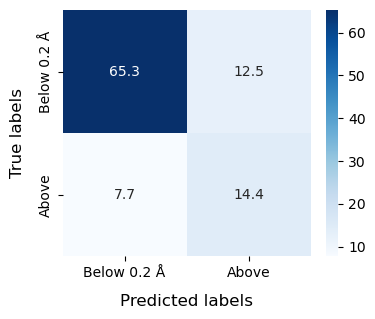

In [48]:
# Confusion matrix using percentages
y_true = []
y_pred = []

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(labels)):
            y_true.append(labels[j].item())
            y_pred.append(predicted[j].item())

cm = confusion_matrix(y_true, y_pred)
cm = 100 * cm.astype('float') / cm.sum(axis=(0,1))

# Plot the confusion matrix with percentages
fig, ax = plt.subplots(figsize=(4, 3.2))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', ax=ax)

# Labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=12, labelpad=10)
ax.set_ylabel('True labels', fontsize=12, labelpad=10)
#ax.set_title('Confusion Matrix')


ax.xaxis.set_ticklabels(['Below ' + str(RMSD_THRESHOLD) + ' Å', 'Above'])
ax.yaxis.set_ticklabels(['Below ' + str(RMSD_THRESHOLD) + ' Å', 'Above'])


# Show the confusion matrix
plt.show()

In [51]:
EXAMPLES = 1000

model.eval()
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

for i in range(EXAMPLES):
    with torch.no_grad():
        random_test_residue = test_dataset[random.randint(0, len(test_dataset))]
        random_test_feature = random_test_residue[0].cuda()
        random_test_label = random_test_residue[1]
        random_test_output = model(random_test_feature.unsqueeze(0))
        _, random_test_predicted = torch.max(random_test_output.data, 1)
        if random_test_label == 1 and random_test_predicted.item() == 1:
            true_positive += 1
        elif random_test_label == 0 and random_test_predicted.item() == 1:
            false_positive += 1
        elif random_test_label == 0 and random_test_predicted.item() == 0:
            true_negative += 1
        elif random_test_label == 1 and random_test_predicted.item() == 0:
            false_negative += 1
        #print("Label: ", random_test_label, "Predicted: ", random_test_predicted.item(), "Corrrect: ", random_test_label == random_test_predicted.item())
print("True positive rate: ", 100*true_positive/EXAMPLES, "%")
print("False positive rate: ", 100*false_positive/EXAMPLES, "%")
print("True negative rate: ", 100*true_negative/EXAMPLES, "%")
print("False negative rate: ", 100*false_negative/EXAMPLES, "%")

True positive rate:  15.3 %
False positive rate:  11.3 %
True negative rate:  66.4 %
False negative rate:  7.0 %


torch.Size([1, 2]) tensor([[ 1.6477, -1.3269]], device='cuda:1')
torch.Size([1, 2]) tensor([[-1.7400,  1.3738]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.1555, -0.0206]], device='cuda:1')
torch.Size([1, 2]) tensor([[-1.3775,  1.0597]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.4460,  0.2653]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.9486,  0.6974]], device='cuda:1')
torch.Size([1, 2]) tensor([[ 1.1756, -0.9246]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.6480,  0.4167]], device='cuda:1')
torch.Size([1, 2]) tensor([[ 0.7949, -0.6765]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.2083,  0.0609]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.6753,  0.4751]], device='cuda:1')
torch.Size([1, 2]) tensor([[-1.2310,  0.9584]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.7484,  0.5529]], device='cuda:1')
torch.Size([1, 2]) tensor([[ 0.2557, -0.3256]], device='cuda:1')
torch.Size([1, 2]) tensor([[-0.3724,  0.2233]], device='cuda:1')
torch.Size([1, 2]) tensor

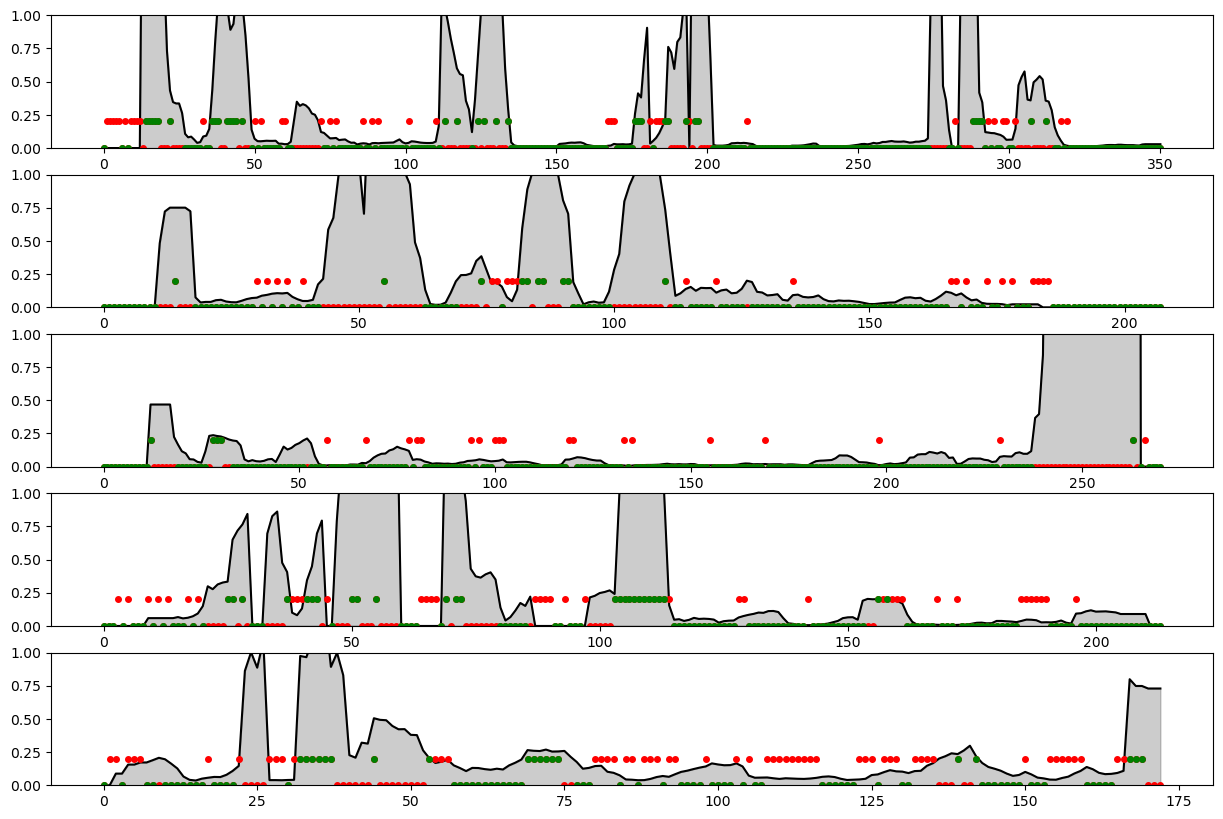

In [20]:
#model.eval()
SUBPLOTS = 5

fig = plt.figure(figsize=(SUBPLOTS*3, 10))

for i in range(SUBPLOTS):
    # Add subplot vertically
    ax = fig.add_subplot(SUBPLOTS, 1, i+1)

    # Test for a single protein
    test_protein = dataset_orig[random.randint(0, len(dataset_orig))]

    # Get the predicted labels for each residue
    predicted_labels = []
    #predicted_labels_weighted = []
    #consensus_labels = []
    with torch.no_grad():
        for residue in test_protein[0]:
            residue = residue.cuda()
            residue = residue.unsqueeze(0)
            
            output = model(residue)
            print(output.shape, output.data)
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted.item()*RMSD_THRESHOLD)

            #output_weighted = model_weighted(residue)
            #_, predicted_weighted = torch.max(output_weighted.data, 1)
            #predicted_labels_weighted.append(predicted_weighted.item()*RMSD_THRESHOLD)
            #
            #
            #if predicted.item() == predicted_weighted.item():
            #    consensus_labels.append(predicted.item()*RMSD_THRESHOLD)
            

    # Get the actual labels for each residue
    actual_labels = []
    correct_labels = []
    for residue in test_protein[1]:
        actual_labels.append(residue)
        correct_labels.append(int(residue >= RMSD_THRESHOLD))

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(len(predicted_labels)):
        if correct_labels[i] == 1 and predicted_labels[i] == RMSD_THRESHOLD:
            correctly_predicted_labels.append(RMSD_THRESHOLD)
        elif correct_labels[i] == 0 and predicted_labels[i] == 0:
            correctly_predicted_labels.append(0)
        else:
            correctly_predicted_labels.append(None)
    
    ## Get a list of correctly predicted consensus labels
    #correctly_predicted_consensus_labels = []
    #for i in range(len(consensus_labels)):
    #    if correct_labels[i] == 1 and consensus_labels[i] == RMSD_THRESHOLD:
    #        correctly_predicted_consensus_labels.append(RMSD_THRESHOLD)
    #    elif correct_labels[i] == 0 and consensus_labels[i] == 0:
    #        correctly_predicted_consensus_labels.append(0)
    #    else:
    #        correctly_predicted_consensus_labels.append(None)
    
    

    # Plot the actual labels as black
    ax.plot(actual_labels, color='black')
    # Make the markers a little bit smaller
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None', markersize=4)
    ax.plot(correctly_predicted_labels, color='green', marker='o', linestyle='None', markersize=4)
    #ax.plot(consensus_labels, color='blue', marker='s', linestyle='None')
    #ax.plot(correctly_predicted_consensus_labels, color='orange', marker='s', linestyle='None')
    ax.set_ylim(0, RMSD_THRESHOLD*5)
    # Fill under the curve
    ax.fill_between(range(len(actual_labels)), actual_labels, color='black', alpha=0.2)

plt.show()


    

In [ ]:
model.eval()
SUBPLOTS = 2

fig = plt.figure(figsize=(15, SUBPLOTS*2))

for i in range(SUBPLOTS):
    # Add subplot vertically
    ax = fig.add_subplot(SUBPLOTS, 1, i+1)

    # Test for a single protein
    test_protein = dataset_orig[random.randint(0, len(dataset_orig))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        for residue in test_protein[0]:
            residue = residue.cuda()
            residue = residue.unsqueeze(0)
            output = model(residue)
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted.item()*RMSD_THRESHOLD)
            

    # Get the actual labels for each residue
    actual_labels = []
    correct_labels = []
    for residue in test_protein[1]:
        actual_labels.append(residue)
        correct_labels.append(int(residue >= RMSD_THRESHOLD))

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(len(predicted_labels)):
        if correct_labels[i] == 1 and predicted_labels[i] == RMSD_THRESHOLD:
            correctly_predicted_labels.append(RMSD_THRESHOLD)
        elif correct_labels[i] == 0 and predicted_labels[i] == 0:
            correctly_predicted_labels.append(0)
        else:
            correctly_predicted_labels.append(None)
  
    ax.plot(actual_labels, color='black')
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None', markersize=4)
    ax.plot(correctly_predicted_labels, color='green', marker='o', linestyle='None', markersize=4)
    ax.set_ylim(0, RMSD_THRESHOLD*5)
    ax.fill_between(range(len(actual_labels)), actual_labels, color='black', alpha=0.2)

plt.show()